In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import netCDF4

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

## Load Data

In [4]:
sho = netCDF4.Dataset('../data/sho_friction2.nc').variables
t_sho = np.array(sho['t'][:], dtype=np.float32)
s_sho = np.array(sho['s'][:], dtype=np.float32)
v_sho = np.array(sho['v'][:], dtype=np.float32)

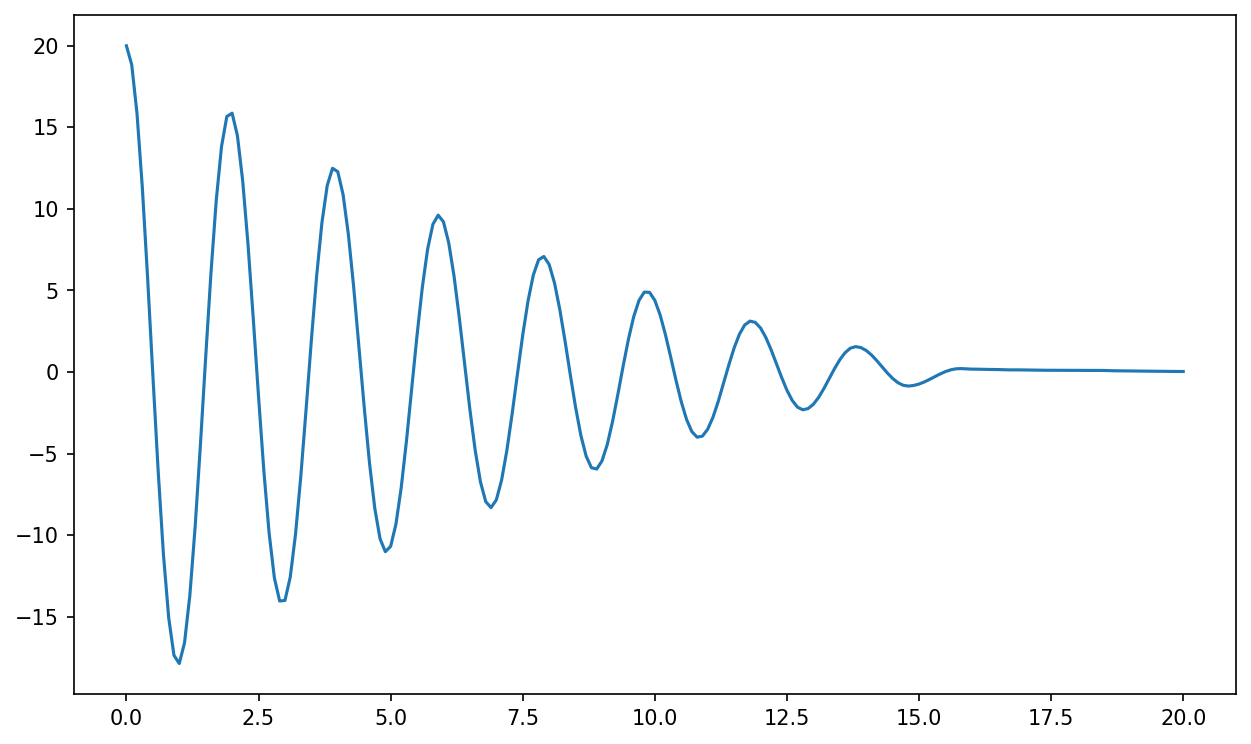

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, s_sho)
plt.show()

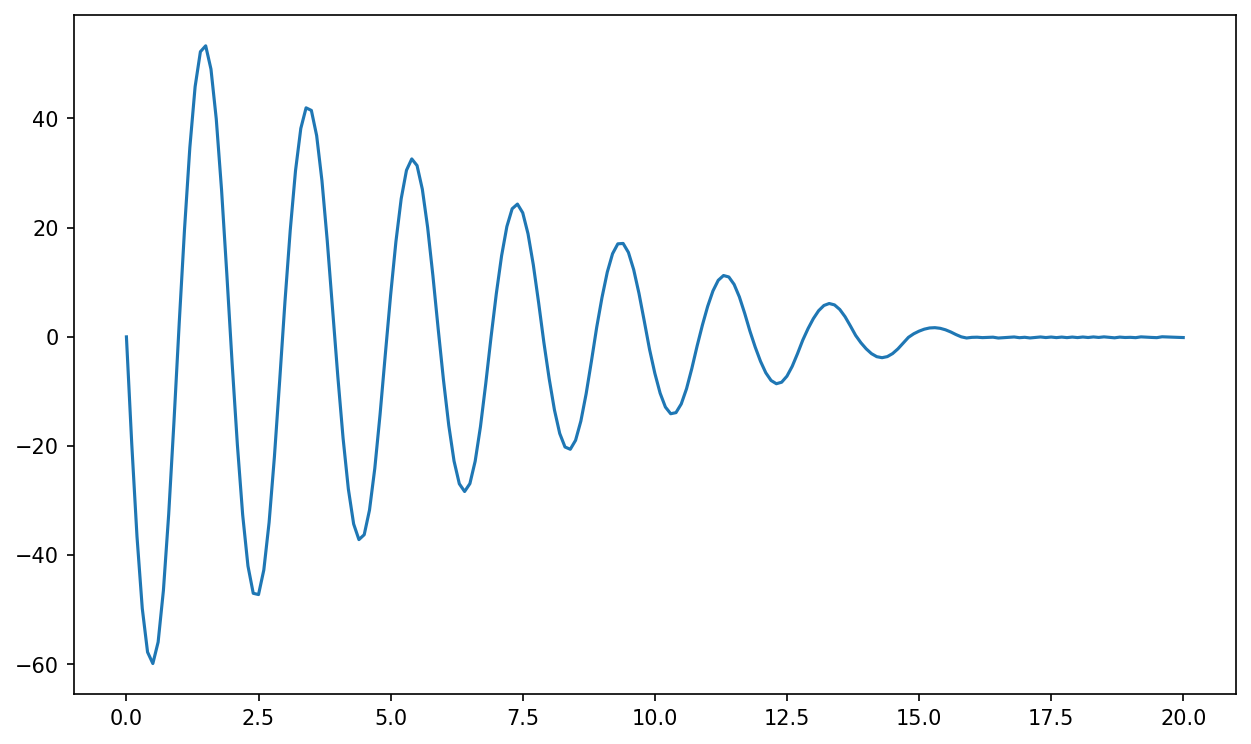

In [6]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, v_sho)
plt.show()

In [7]:
# X_total = np.column_stack([s_sho, v_sho])
X_total = s_sho.reshape(-1, 1)
sc = MinMaxScaler()
X_normalized = sc.fit_transform(X_total)

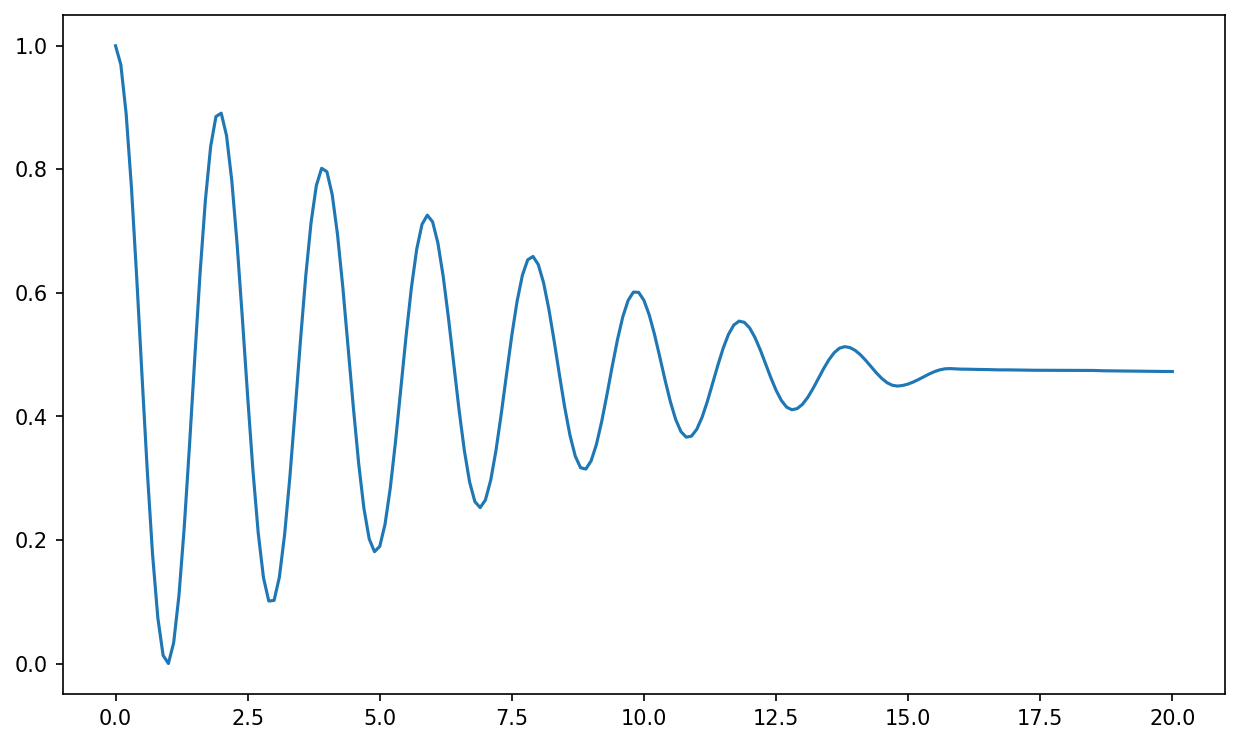

In [8]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, X_normalized[:,0])
plt.show()

In [9]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [10]:
def train_test(df, test_periods):
    train = df[:-test_periods]
    test = df[-test_periods:]
    return train, test

In [11]:
X, y = sliding_window(X_normalized, 10)

In [12]:
X.shape

(190, 10, 1)

In [13]:
y.shape

(190, 1)

In [14]:
N = X.shape[0]
N_train = 100
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:150]
y_test = y[N_train:150]

In [15]:
class NewtonData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
ds_train = NewtonData(X_train, y_train)
ds_val = NewtonData(X_test, y_test)

In [17]:
len(ds_train)

100

In [18]:
len(ds_val)

50

In [19]:
ds_train[0][0].shape

(10, 1)

In [20]:
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True)

In [21]:
ds_train[0]

(array([[1.        ],
        [0.9694807 ],
        [0.8905688 ],
        [0.7718029 ],
        [0.6256945 ],
        [0.46729314],
        [0.3126407 ],
        [0.17715085],
        [0.07407665],
        [0.01321888]], dtype=float32),
 array([0.], dtype=float32))

In [22]:
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, 1, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # input shape: batch, seq, dim
        rnn_output, _ = self.rnn(x)
        output = self.fc(rnn_output)
        
        return output[:,-1,:]

In [30]:
model = SingleRNN(input_size=1, hidden_size=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
model.eval()
dl_iter = iter(dl_train)
x_one, y_one = next(dl_iter)

In [32]:
x_one.shape

torch.Size([10, 10, 1])

In [33]:
y_one.shape

torch.Size([10, 1])

In [34]:
model(x_one).shape

torch.Size([10, 1])

In [35]:
epochs = 500
model.train()
for epoch in range(epochs+1):
    for x, y in dl_train:
        y_hat = model(x)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.18823907
epoch:  100 loss:0.00012492
epoch:  200 loss:0.00003303
epoch:  300 loss:0.00006098
epoch:  400 loss:0.00001842
epoch:  500 loss:0.00000927


In [36]:
model.eval()

SingleRNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [115]:
X, y = sliding_window(X_normalized, 10)

In [116]:
total_data = NewtonData(X, y)

In [117]:
dl = DataLoader(total_data, batch_size=len(total_data))
dl_iter = iter(dl)
X, y = next(dl_iter)

In [118]:
y.shape

torch.Size([190, 1])

In [119]:
t = t_sho[10:-1]
t.shape

(190,)

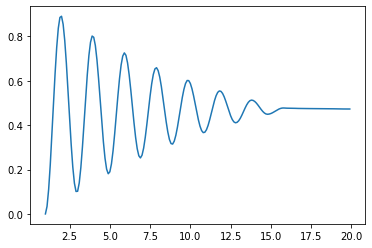

In [120]:
plt.plot(t, y.cpu().numpy())

In [121]:
y_pred = model(X)

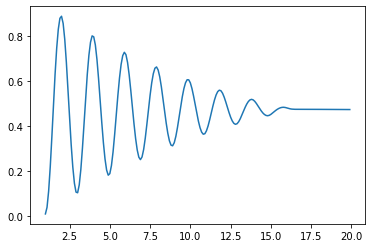

In [122]:
plt.plot(t, y_pred.detach().numpy())

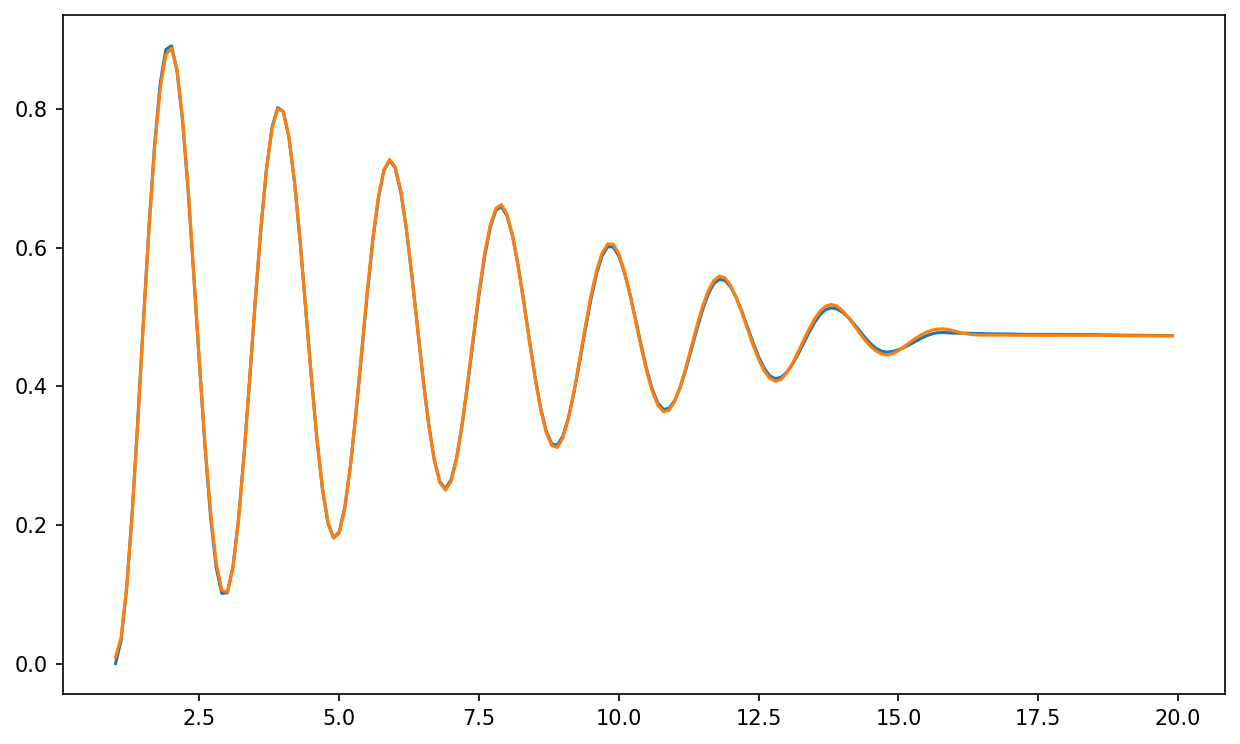

In [123]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t, y.cpu().numpy())
plt.plot(t, y_pred.detach().numpy())
plt.show()

In [124]:
X.shape

torch.Size([190, 10, 1])

In [125]:
t.shape

(190,)

In [126]:
N_extrap = 190
X_new = X[0]
X_new.shape

torch.Size([10, 1])

In [127]:
X_new.view(1,-1,1)

tensor([[[1.0000],
         [0.9695],
         [0.8906],
         [0.7718],
         [0.6257],
         [0.4673],
         [0.3126],
         [0.1772],
         [0.0741],
         [0.0132]]])

In [128]:
y_ex = []
t_ex = []
dt = 1e-1
for i in range(N_extrap):
    y_new = model(X_new.view(1, -1, 1))
    X_new = torch.concat([X_new[1:], y_new])
    t_ex.append(t[0] + i * dt)
    y_ex.append(y_new.view(-1).detach().numpy())

In [129]:
# t_total = np.concatenate([t[0], t_ex])
t_total = t_ex
# y_pred_total = np.concatenate([y_pred.detach().numpy()[0:100], y_ex])
y_pred_total = y_ex

In [130]:
shoo = netCDF4.Dataset('../data/sho_friction3.nc').variables
t_shoo = np.array(shoo['t'][:], dtype=np.float32)
s_shoo = np.array(shoo['s'][:], dtype=np.float32)
v_shoo = np.array(shoo['v'][:], dtype=np.float32)

In [131]:
sc = MinMaxScaler()
s_shoo_new = sc.fit_transform(s_shoo.reshape(-1, 1))

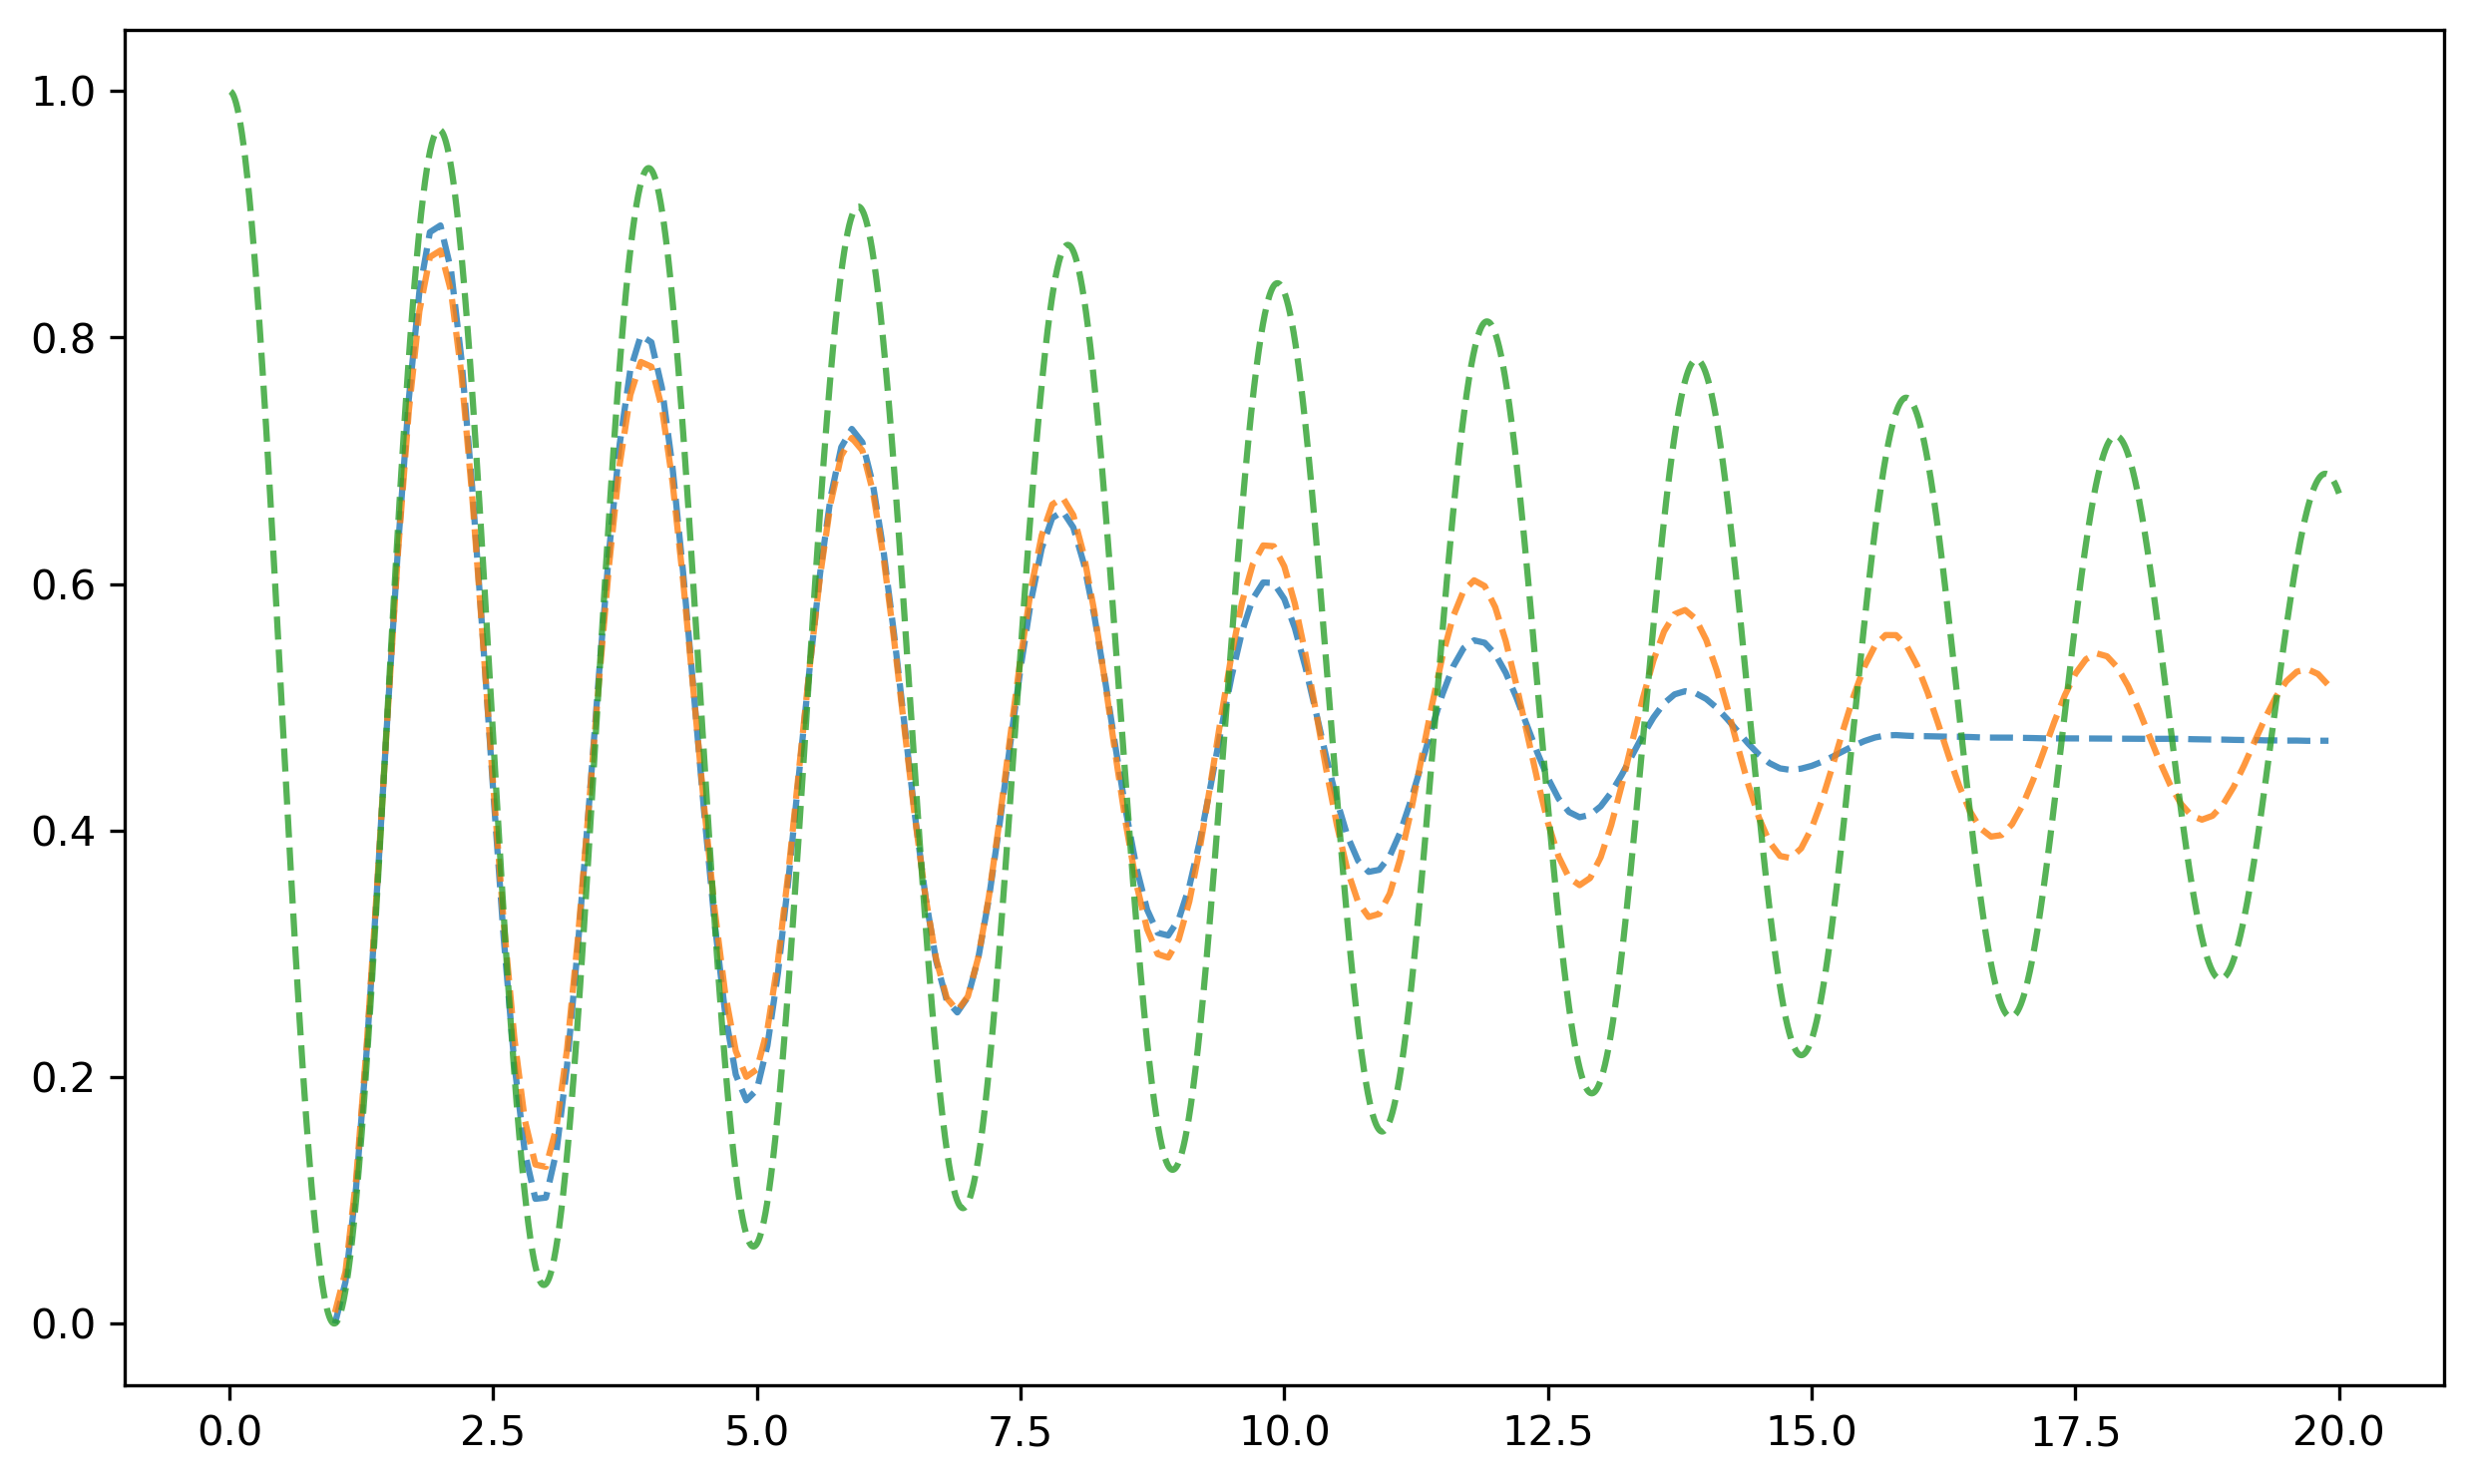

In [132]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t, y.cpu().numpy(), '--', alpha=0.8)
plt.plot(t_total, y_pred_total, '--', alpha=0.8)
plt.plot(t_shoo[10:], s_shoo_new[10:], '--', alpha=0.8)

# plt.axvline(t[100], linestyle='--', color='r')
plt.show()